### Instalación de paquetes
Descomentar si no están instalados los paquetes

In [101]:
# !pip install spotipy


In [102]:
# !pip install tqdm


In [103]:
# !pip install pandas

In [104]:
# !pip install scikit-learn

In [105]:
# !pip install catboost

In [106]:
# !pip install numpy

In [107]:
# !pip install seaborn

### Exploración de los datos

In [1]:
#############! 1. EXPLORACION DE LOS DATOS #############
import pandas as pd
canciones = pd.read_csv("competition_data.csv", index_col=0)

print(f'cantidad de filas: {canciones.shape[0]}')
print(f'cantidad de columnas: {canciones.shape[1]}')
cant_nan = (canciones.isnull().sum().sum()/(canciones.shape[0]*canciones.shape[1]))*100
print(f"Total de valores faltantes en el dataset: {round(cant_nan,2)} %")
#balanceados los datos?

porcentaje_false = ((canciones[canciones["TARGET"]==0]).shape[0]/canciones.shape[0])*100
print(f"Porcentje de falsos: {porcentaje_false} %")
print(f"Cantidad de valores faltanes por columna: {canciones.isnull().sum()}")



cantidad de filas: 100144
cantidad de columnas: 12
Total de valores faltantes en el dataset: 1.69 %
Porcentje de falsos: 47.32385365074293 %
Cantidad de valores faltanes por columna: ts                                       0
username                                 0
platform                                 0
conn_country                             0
user_agent_decrypted                 16397
master_metadata_track_name             973
master_metadata_album_artist_name      973
master_metadata_album_album_name       973
spotify_track_uri                      973
reason_start                             4
shuffle                                  0
TARGET                                   0
dtype: int64


In [2]:
## Queriamos corrobar si cuando le falta a uno de las tres columnas, efectivamente le falta a las tres 
# Definir las columnas a verificar
columnas_objetivo = [
    "master_metadata_track_name",
    "master_metadata_album_artist_name",
    "master_metadata_album_album_name"
]

# Filtrar filas donde las tres columnas sean NaN
filas_faltantes = canciones[canciones[columnas_objetivo].isnull().all(axis=1)]

# Seleccionar solo las columnas deseadas (las tres columnas + user_id)
columnas_a_mostrar = columnas_objetivo + ["username"]
resultado = filas_faltantes[columnas_a_mostrar]

# Mostrar resultados
print(resultado)
print(f"Cantidad de filas donde faltan los tres atributos: {resultado.shape[0]}")



       master_metadata_track_name master_metadata_album_artist_name  \
546                           NaN                               NaN   
70405                         NaN                               NaN   
48823                         NaN                               NaN   
61197                         NaN                               NaN   
33434                         NaN                               NaN   
...                           ...                               ...   
123234                        NaN                               NaN   
60847                         NaN                               NaN   
38735                         NaN                               NaN   
86422                         NaN                               NaN   
65180                         NaN                               NaN   

       master_metadata_album_album_name     username  
546                                 NaN  11145402699  
70405                               N

---------------
Dividimos los datos en train y test, para poder explorar las correlaciones solo en train porque modificamos cosas

In [3]:
from sklearn.model_selection import train_test_split

####### Divido los datos en train y test ########
y = canciones["TARGET"]  # target: lo que quiero predecir
X = canciones.drop(columns=["TARGET"])  # features: todo lo demás


# Dividir en 90% entrenamiento y 10% validación
X_train, X_test, y_train, y_test = train_test_split(
   X, y,
   test_size=0.1,
   random_state=42,
   stratify=y  # Mantiene proporciones del target
)


-------------

#### Matrices de Cramer - Análisis de Correlación

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols


# Columnas categóricas
categorical_cols = [
    "platform", "conn_country", "user_agent_decrypted", "master_metadata_track_name", 
    "master_metadata_album_artist_name", "master_metadata_album_album_name", 
    "spotify_track_uri", "reason_start", "shuffle"
]
categorical_cols = list(set(categorical_cols))  # quitar duplicados

# Revisar y reemplazar valores nulos en X_train
for col in categorical_cols:
    if col in X_train.columns:
        X_train[col].fillna('unknown', inplace=True)

# Procesar fechas en X_train
X_train["ts"] = pd.to_datetime(X_train["ts"], utc=True)
X_train["año"] = X_train["ts"].dt.year

# Crear nuevas columnas en X_train
X_train['platform_by_year'] = X_train['platform'].astype(str) + '_' + X_train['año'].astype(str)
#X_train.drop(columns=["platform", "año"], inplace=True, errors='ignore')

# Actualizar categorical_cols después del drop
categorical_cols = [col for col in categorical_cols if col in X_train.columns]

# Convertir columnas a categoría en X_train
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')

# Imprimir cantidad de categorías únicas en X_train
for col in categorical_cols:
    print(f'{col} tiene {X_train[col].nunique()} categorías')

# Función para calcular Cramér's V
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    else:
        return np.nan

""" # Crear DataFrame vacío para Cramér's V
cramers_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

# Calcular matriz de Cramér's V usando X_train
for col1 in categorical_cols:
    for col2 in categorical_cols:
        cramers_matrix.loc[col1, col2] = cramers_v(X_train[col1], X_train[col2])

# Convertir a float
cramers_matrix = cramers_matrix.astype(float)

# Graficar matriz de correlación
plt.figure(figsize=(10, 7))
sns.heatmap(cramers_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show() """
print(X_train.columns)


shuffle tiene 2 categorías
conn_country tiene 7 categorías
user_agent_decrypted tiene 20 categorías
platform tiene 74 categorías
master_metadata_album_artist_name tiene 3042 categorías
reason_start tiene 9 categorías
master_metadata_track_name tiene 8139 categorías
spotify_track_uri tiene 9644 categorías
master_metadata_album_album_name tiene 5994 categorías
Index(['ts', 'username', 'platform', 'conn_country', 'user_agent_decrypted',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'reason_start',
       'shuffle', 'año', 'platform_by_year'],
      dtype='object')


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Supongamos que este es tu DataFrame y ya tiene la columna 'TARGET'
# Asegúrate de reemplazar esto con tu carga real de datos
# df = pd.read_csv("tu_archivo.csv")


# Crea la carpeta de salida si no existe
os.makedirs('plots', exist_ok=True)

# Generar y guardar cada gráfico
for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=canciones, x=col, hue='TARGET', order=canciones[col].value_counts().iloc[:10].index)
    plt.title(f'Distribución de {col} por target')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    filename = f'plots/{col}_vs_target.png'
    plt.savefig(filename)
    plt.close()

print('Creada la carpeta PLOT con todos los graficos de las variables categoricas vs target ')

/var/folders/jc/_3wsvphd4bgdb6n9q0pwhp0c0000gp/T/ipykernel_41479/1135505851.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


Creada la carpeta PLOT con todos los graficos de las variables categoricas vs target 


................................................................................................
### Preparación de los datos
Modificación del dataset con el objetivo de mejorar performance del modelo

In [ ]:
from sklearn.model_selection import train_test_split
import catboost as cb
import matplotlib.pyplot as plt
import pandas as pd

# --- Lista base de columnas categóricas ---
categorical_cols = [
    "master_metadata_track_name", "master_metadata_album_artist_name",
    "reason_start", "semana", "dia_hora",
    "shuffle", "mes"
]

# --- Función para procesar datos ---
def modify_file(f, categorical_cols):
    if "Unnamed: 0" in f.columns:
        f = f.rename(columns={"Unnamed: 0": "ID"})

    # Procesar timestamps
    f["ts"] = pd.to_datetime(f["ts"], utc=True)
    f["año"] = f["ts"].dt.year
    f["mes"] = f["ts"].dt.month
    f["dia_semana"] = f["ts"].dt.weekday
    f["semana"] = f["ts"].dt.isocalendar().week
    f["hora"] = f["ts"].dt.hour
    f["ts"] = f["ts"].astype("int64") // 10**9
    f["dia_hora"] = f["dia_semana"].astype(str) + "_" + f["hora"].astype(str)

    # Crear columna combinada platform_by_year si existe 'platform'
    if "platform" in f.columns:
        f["platform_by_year"] = f["platform"].astype(str) + "_" + f["año"].astype(str)
        f.drop(columns=["platform", "año"], inplace=True)

    # Rellenar valores faltantes en las categóricas (forma segura)
    for col in categorical_cols:
        if col in f.columns:
            f[col] = f[col].astype(str).fillna("unknown")

    # Drop columnas innecesarias
    f = f.drop(columns=[
        "spotify_track_uri", "username", "master_metadata_album_album_name",
        "user_agent_decrypted", "conn_country", "hora", "dia_semana", "ts"
    ], errors='ignore')

    # Limpiar nombres de columnas
    f.columns = f.columns.str.replace(r"[^\w]", "_", regex=True).str.lower()

    if "ID" in f.columns:
        f = f.set_index("ID")
    return f

# --- Preprocesar datos ---
X_train = modify_file(X_train, categorical_cols)
X_test = modify_file(X_test, categorical_cols)

for col in ['dia_hora', 'platform_by_year']:
    if col in X_train.columns and col not in categorical_cols:
        categorical_cols.append(col)


# --- Features de conteo por track y artista ---
track_counts = X_train['master_metadata_track_name'].value_counts()
artist_counts = X_train['master_metadata_album_artist_name'].value_counts()

X_train['track_play_count'] = X_train['master_metadata_track_name'].map(track_counts)
X_test['track_play_count'] = X_test['master_metadata_track_name'].map(track_counts).fillna(0)

X_train['artist_play_count'] = X_train['master_metadata_album_artist_name'].map(artist_counts)
X_test['artist_play_count'] = X_test['master_metadata_album_artist_name'].map(artist_counts).fillna(0)

# --- Asegurar tipos correctos ---
X_train['track_play_count'] = X_train['track_play_count'].astype(int)
X_test['track_play_count'] = X_test['track_play_count'].astype(int)
X_train['artist_play_count'] = X_train['artist_play_count'].astype(int)
X_test['artist_play_count'] = X_test['artist_play_count'].astype(int)

# --- Eliminar features de conteo de las categóricas si se agregaron por error ---
categorical_cols = [col for col in categorical_cols if col not in ['track_play_count', 'artist_play_count']]

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# --- Crear Pools para CatBoost ---
train_data = cb.Pool(X_train, label=y_train, cat_features=categorical_cols)
test_data = cb.Pool(X_test, label=y_test, cat_features=categorical_cols)


/var/folders/jc/_3wsvphd4bgdb6n9q0pwhp0c0000gp/T/ipykernel_41479/161246092.py:25: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  f["ts"] = f["ts"].astype("int64") // 10**9


Index(['master_metadata_track_name', 'master_metadata_album_artist_name',
       'reason_start', 'shuffle', 'platform_by_year', 'mes', 'semana',
       'dia_hora', 'track_play_count', 'artist_play_count'],
      dtype='object')


................................................................................................

Vuelvo a generar la matriz de correlación con los nuevos atributos

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# Asegurarse que las columnas categóricas existan en X_train
categorical_cols = [col for col in categorical_cols if col in X_train.columns]

# Convertir a tipo categoría si no lo están
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')

# Función para calcular Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.shape[0] > 1 and confusion_matrix.shape[1] > 1:
        chi2, p, dof, expected = chi2_contingency(confusion_matrix)
        n = confusion_matrix.sum().sum()
        return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))
    else:
        return np.nan

# Crear matriz vacía
""" cramers_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

# Calcular matriz de Cramér's V
for col1 in categorical_cols:
    for col2 in categorical_cols:
        cramers_matrix.loc[col1, col2] = cramers_v(X_train[col1], X_train[col2])

# Convertir a float
cramers_matrix = cramers_matrix.astype(float)

# Graficar
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Cramér's V entre columnas categóricas")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show() """


' cramers_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)\n\n# Calcular matriz de Cramér\'s V\nfor col1 in categorical_cols:\n    for col2 in categorical_cols:\n        cramers_matrix.loc[col1, col2] = cramers_v(X_train[col1], X_train[col2])\n\n# Convertir a float\ncramers_matrix = cramers_matrix.astype(float)\n\n# Graficar\nplt.figure(figsize=(12, 10))\nsns.heatmap(cramers_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)\nplt.title("Cramér\'s V entre columnas categóricas")\nplt.xticks(rotation=45, ha=\'right\')\nplt.tight_layout()\nplt.show() '

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90129 entries, 114593 to 66939
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   master_metadata_track_name         90129 non-null  category
 1   master_metadata_album_artist_name  90129 non-null  category
 2   reason_start                       90129 non-null  category
 3   shuffle                            90129 non-null  category
 4   platform_by_year                   90129 non-null  category
 5   mes                                90129 non-null  category
 6   semana                             90129 non-null  category
 7   dia_hora                           90129 non-null  category
 8   track_play_count                   90129 non-null  int64   
 9   artist_play_count                  90129 non-null  int64   
dtypes: category(8), int64(2)
memory usage: 3.4 MB


-----------
##### Análisis de Correlación con el Target

platform                             category
conn_country                         category
user_agent_decrypted                 category
master_metadata_track_name           category
master_metadata_album_artist_name    category
master_metadata_album_album_name     category
spotify_track_uri                    category
reason_start                         category
shuffle                              category
TARGET                               category
dtype: object


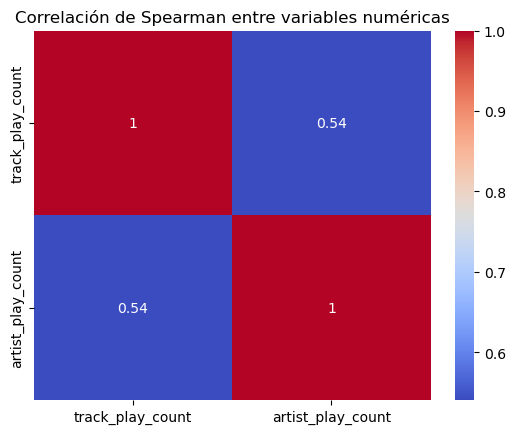

                       sum_sq       df          F        PR(>F)
C(reason_start)  3.421225e+06      8.0  46.873698  6.073233e-76
Residual         8.222116e+08  90120.0        NaN           NaN


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
categorical_cols = [
    "platform", "conn_country", "user_agent_decrypted", "master_metadata_track_name", 
    "master_metadata_album_artist_name", "master_metadata_album_album_name", 
    "spotify_track_uri", "reason_start", "shuffle", "TARGET"
]

# Definimos explícitamente las columnas categóricas (según el gráfico)
canciones=pd.read_csv("competition_data.csv", index_col=0)
canciones["ts"] = pd.to_datetime(canciones["ts"], utc=True)

canciones["año"] = canciones["ts"].dt.year

# Usar X_train en lugar de canciones
canciones['platform_by_year'] = canciones['platform'].astype(str) + '_' + canciones['año'].astype(str)
#canciones.drop(columns=["platform", "año"], inplace=True, errors='ignore') comento esto porq no funciona si no
for col in categorical_cols:
        canciones[col] = canciones[col].astype('category')

# Verificar tipos
print(canciones[categorical_cols].dtypes)

# Función para calcular Cramér's V
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

# Crear un DataFrame vacío para almacenar los resultados de Cramér's V
""" cramers_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

# Calcular la matriz de correlación de Cramér's V
for col1 in categorical_cols:
    for col2 in categorical_cols:
        cramers_matrix.loc[col1, col2] = cramers_v(canciones[col1], canciones[col2])

# Convertir la matriz a tipo float
cramers_matrix = cramers_matrix.astype(float)

# Graficar la matriz de correlación
plt.figure(figsize=(10, 7))
sns.heatmap(cramers_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación Categórica entre Atributos")
plt.show() """

# Solo variables numéricas
numeric_cols = ['track_play_count', 'artist_play_count']

# Calculás Spearman
spearman_corr = X_train[numeric_cols].corr(method='spearman')
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm')
plt.title("Correlación de Spearman entre variables numéricas")
plt.show()
import statsmodels.api as sm
from statsmodels.formula.api import ols

anova = ols('track_play_count ~ C(reason_start)', data=X_train).fit()
anova_table = sm.stats.anova_lm(anova, typ=2)
print(anova_table)



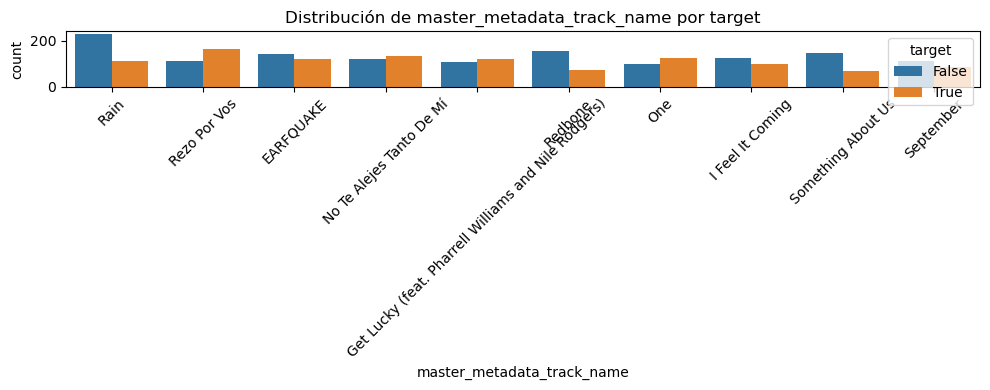

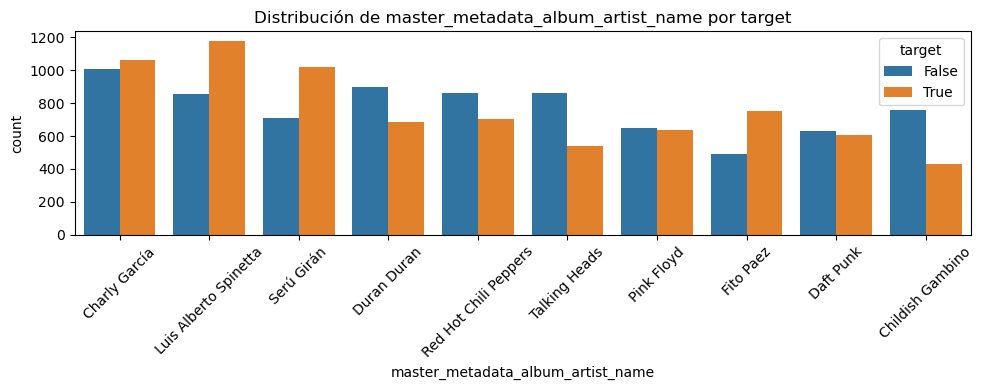

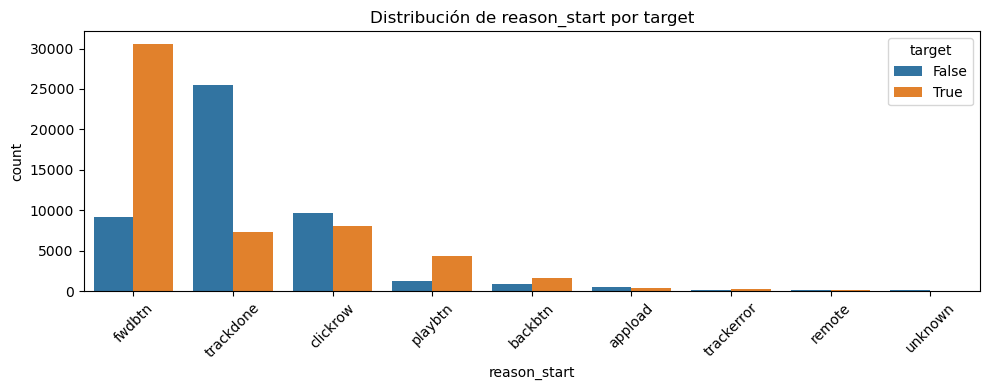

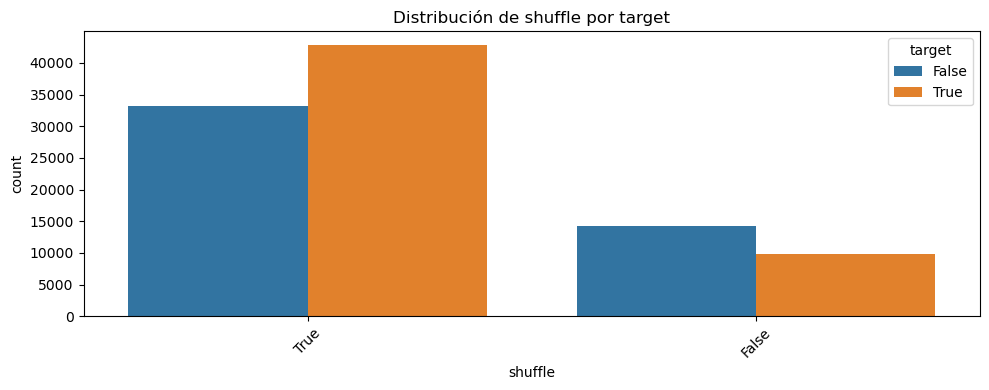

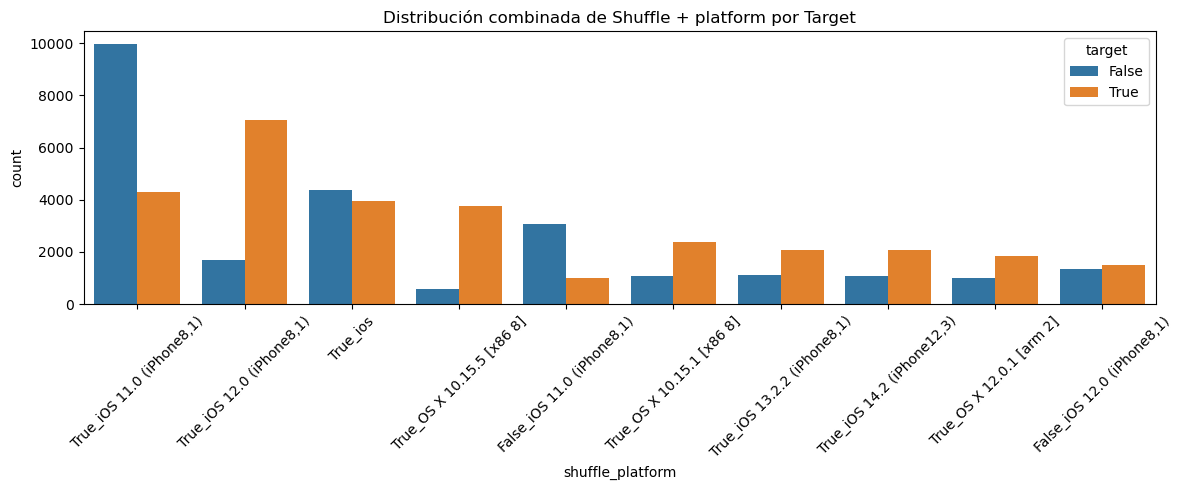

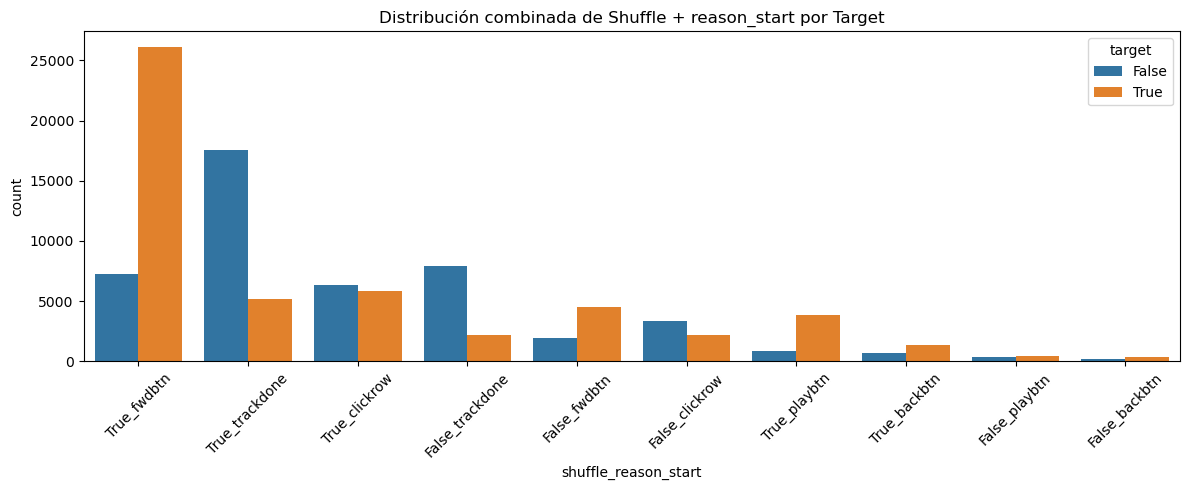

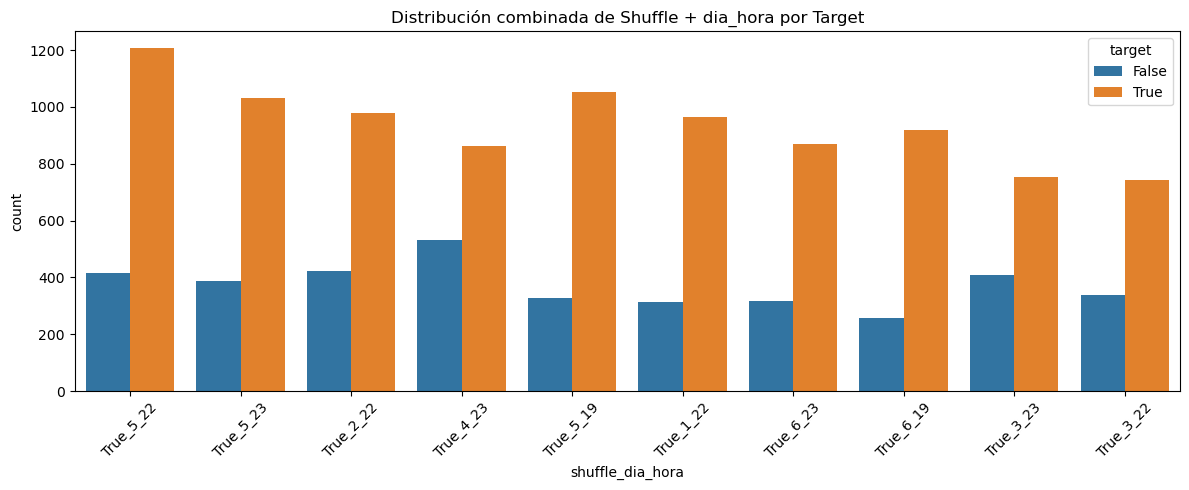

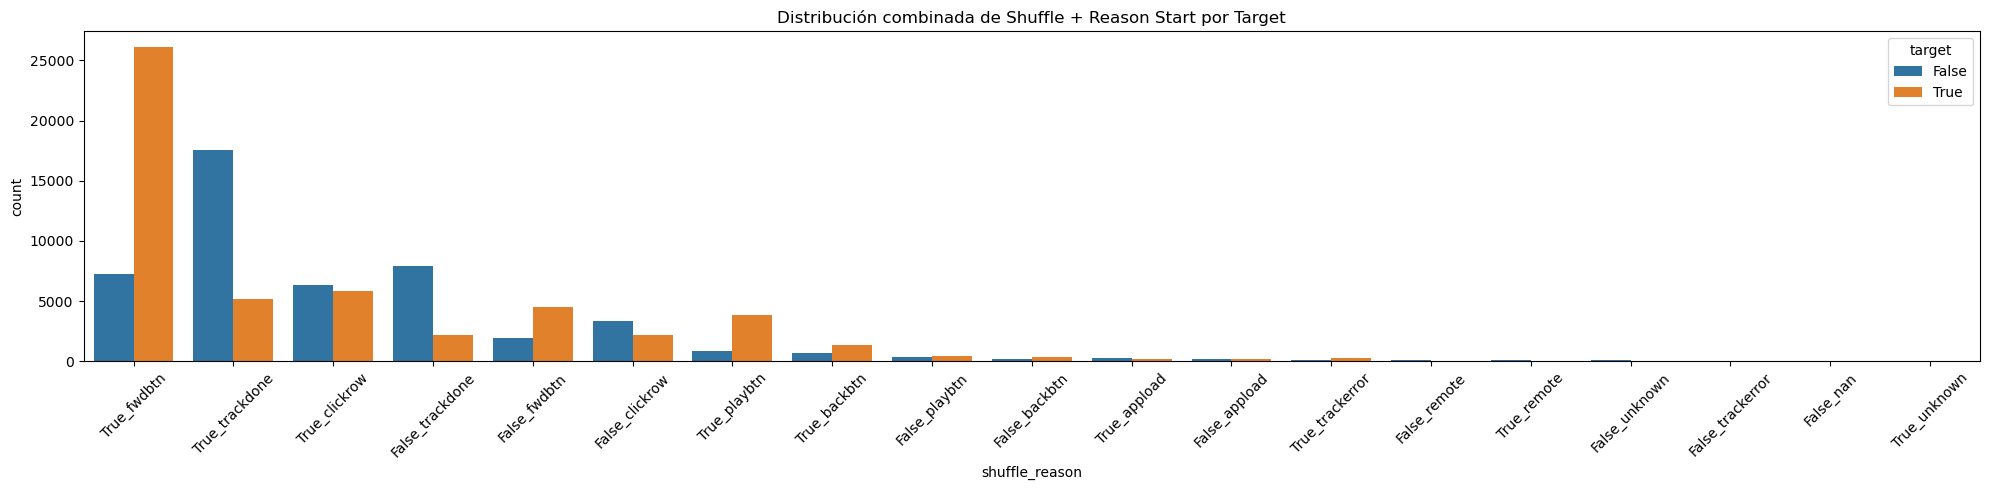

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Cargar y preparar datos ===

canciones.columns = canciones.columns.str.lower()  # Estandarizar nombres a minúsculas

# Convertir timestamp
canciones["ts"] = pd.to_datetime(canciones["ts"], utc=True)

# Crear target si no existe
if "target" not in canciones.columns and "target" in locals():
    canciones["target"] = y
elif "target" not in canciones.columns and "target" in X.columns:
    canciones["target"] = X["target"]

# Crear columnas combinadas
canciones["dia_hora"] = canciones["ts"].dt.weekday.astype(str) + "_" + canciones["ts"].dt.hour.astype(str)
canciones["shuffle_dia"] = canciones["shuffle"].astype(str) + "_" + canciones["dia_hora"].astype(str)
canciones["shuffle_platform"] = canciones["shuffle"].astype(str) + "_" + canciones["platform"].astype(str)
canciones["shuffle_reason"] = canciones["shuffle"].astype(str) + "_" + canciones["reason_start"].astype(str)

# === Gráficos por variable categórica ===
cat_vars = [
    "master_metadata_track_name",
    "master_metadata_album_artist_name",
    "reason_start",
    "shuffle",
]

for col in cat_vars:
    plt.figure(figsize=(10,4))
    sns.countplot(data=canciones, x=col, hue="target", order=canciones[col].value_counts().index[:10])
    plt.title(f'Distribución de {col} por target')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === Función para gráficas combinadas con shuffle ===
def plot_shuffle_combination(df, feature, top_n=10):
    col_name = f"shuffle_{feature}"
    if col_name not in df.columns:
        df[col_name] = df["shuffle"].astype(str) + "_" + df[feature].astype(str)

    orden = df[col_name].value_counts().index[:top_n]

    plt.figure(figsize=(12,5))
    sns.countplot(data=df, x=col_name, hue="target", order=orden)
    plt.title(f"Distribución combinada de Shuffle + {feature} por Target")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === Gráficos combinados con shuffle  ===
plot_shuffle_combination(canciones, "platform")
plot_shuffle_combination(canciones, "reason_start")
plot_shuffle_combination(canciones, "dia_hora")

# === Extra: Top combinaciones de shuffle + reason ===
plt.figure(figsize=(20,5))
sns.countplot(
    data=canciones,
    x="shuffle_reason",
    hue="target",
    order=canciones["shuffle_reason"].value_counts().index[:20]
)
plt.title("Distribución combinada de Shuffle + Reason Start por Target")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


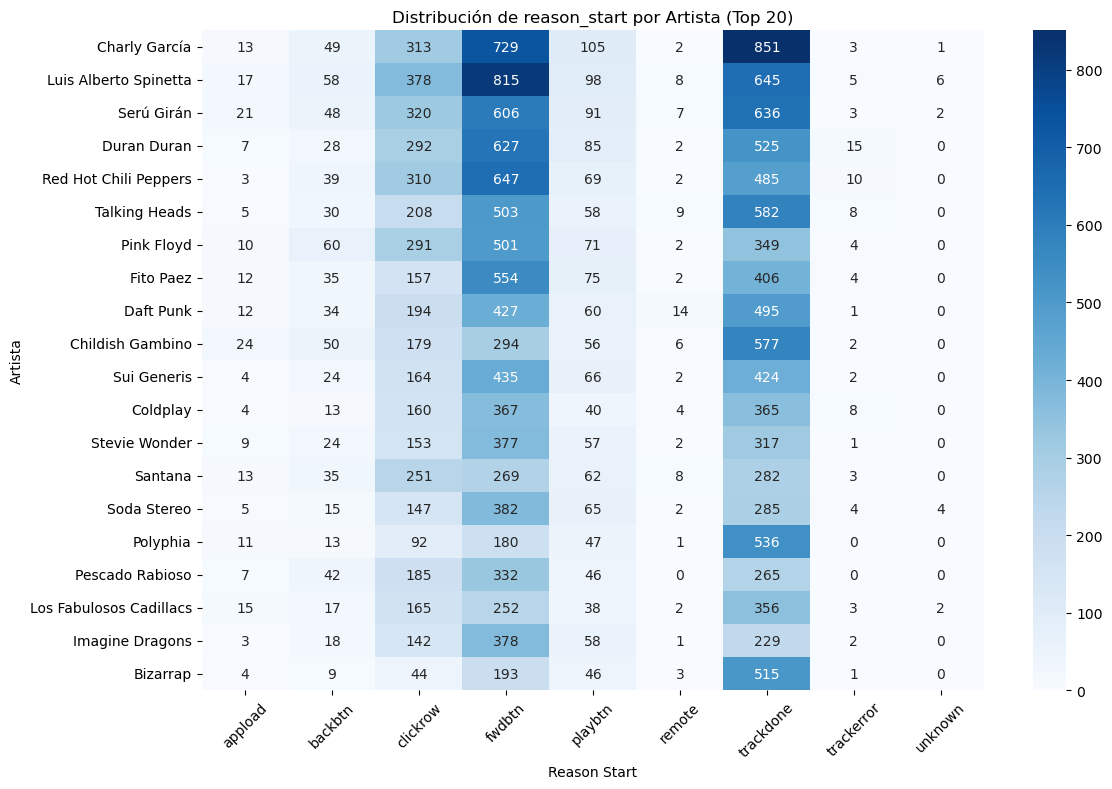

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear tabla dinámica (pivot) con la cuenta de reproducciones por reason_start y artista
razones_por_artista = canciones.pivot_table(
    index='master_metadata_album_artist_name',
    columns='reason_start',
    aggfunc='size',
    fill_value=0
)

# Alternativa A: ordenar por "algorithmic" si existe
if 'algorithmic' in razones_por_artista.columns:
    razones_por_artista = razones_por_artista.sort_values(by='algorithmic', ascending=False)

# Alternativa B: si no existe, ordenar por el total de reproducciones (sumando todas las razones)
else:
    razones_por_artista['total'] = razones_por_artista.sum(axis=1)
    razones_por_artista = razones_por_artista.sort_values(by='total', ascending=False)
    razones_por_artista = razones_por_artista.drop(columns='total')  # Sacar la columna auxiliar

# Mostrar los primeros 20 artistas en un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(razones_por_artista.head(20), annot=True, fmt='d', cmap='Blues')
plt.title("Distribución de reason_start por Artista (Top 20)")
plt.xlabel("Reason Start")
plt.ylabel("Artista")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/jc/_3wsvphd4bgdb6n9q0pwhp0c0000gp/T/ipykernel_41479/3069189884.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=canciones, x="dia_semana_nombre", y="target", ci=None)


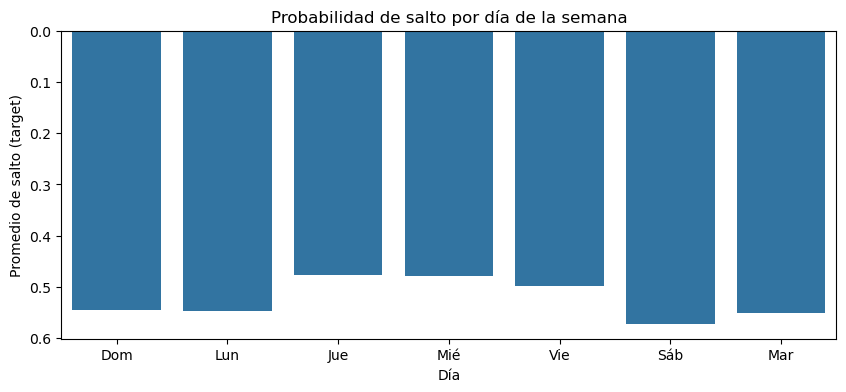

In [12]:
#semana , mes , dia_hora comento esto que no entiendo que es
dias = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
canciones["dia_semana"] = canciones["ts"].dt.weekday  # 0 = lunes
canciones["dia_semana_nombre"] = canciones["dia_semana"].map(dict(zip(range(7), dias)))

plt.figure(figsize=(10, 4))
sns.barplot(data=canciones, x="dia_semana_nombre", y="target", ci=None)
plt.title("Probabilidad de salto por día de la semana")
plt.xlabel("Día")
plt.ylabel("Promedio de salto (target)")
plt.show()


--------------
#### Búsqueda de hiperparámetros

In [15]:
import pandas as pd
import catboost as cb
from sklearn.model_selection import RandomizedSearchCV

categorical_cols_nuevas = ['master_metadata_track_name', 'master_metadata_album_artist_name',
       'reason_start', 'shuffle', 'platform_by_year', 'mes', 'semana',
       'dia_hora', 'track_play_count', 'artist_play_count'] 

modelo = cb.CatBoostClassifier(verbose=0, loss_function='Logloss', eval_metric='AUC', random_seed=42,cat_features=categorical_cols_nuevas, early_stopping_rounds=50)

grid_params = {
   'iterations': [100, 200, 300],  # Número de iteraciones
   'learning_rate': [0.01, 0.05, 0.1],  # Tasa de aprendizaje
   'depth': [4, 6, 8],  # Profundidad del árbol
   'l2_leaf_reg': [1, 3, 5, 7],  # Regularización L2
}
print(X_train.columns)
best_params = modelo.grid_search(
   grid_params, 
   X=X_train,  # Datos de entrenamiento
   y=y_train,        # No es necesario especificar y porque está en el Pool
   cv=5,  # Número de folds para la validación cruzada
   partition_random_seed=42
)



Index(['master_metadata_track_name', 'master_metadata_album_artist_name',
       'reason_start', 'shuffle', 'platform_by_year', 'mes', 'semana',
       'dia_hora', 'track_play_count', 'artist_play_count'],
      dtype='object')

bestTest = 0.884818346
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8848183	best: 0.8848183 (0)	total: 1.51s	remaining: 2m 42s

bestTest = 0.897739978
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8977400	best: 0.8977400 (1)	total: 2.81s	remaining: 2m 28s

bestTest = 0.9019412004
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.9019412	best: 0.9019412 (2)	total: 4.13s	remaining: 2m 24s

bestTest = 0.8848645756
be

### Entrenamiento del modelo 
Entrenamiento del modelo con los mejores hiperparámetros encontrados.
Calculo el AUC de la performance del modelo sobre el conjunto de test (10% aleatorio del dataset original). Pruebo sobre el test para comparar la performance de los distintos modelos luego de modificaciones, ya que en la submission del kaggle solo tenemos 3 pruebas por día.

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from catboost import Pool

'''
# best{'params': {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300},
solo_parametros = best_params["params"]
# Entrenar el modelo
modelofinal = cb.CatBoostClassifier(**solo_parametros, cat_features=categorical_cols, verbose=100)

# Entrenar SOLO con datos de entrenamiento
modelofinal.fit(X_train, y_train)
y_pred_proba = modelofinal.predict_proba(X_test)[:, 1]

'''



solo_parametros = best_params["params"]
#solo_parametros =  {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300}
modelofinal = cb.CatBoostClassifier(**solo_parametros, cat_features=categorical_cols_nuevas, verbose=100) #cambio esto

modelofinal.fit(X_train, y_train)

""" # Ya está entrenado con fit durante el RandomizedSearchCV
y_pred_proba = modelofinal.predict_proba(X_test)[:, 1]
y_test_bin = y_test.astype(int) """

# nuevo. 
# Usar el orden exacto que espera el modelo entrenado


# Asegurar que las categóricas estén en el conjunto de columnas actuales
categorical_cols_nuevas = [col for col in categorical_cols_nuevas if col in X_test.columns]

# Reorder columns in X_test to match the order in X_train
X_test = X_test[X_train.columns]

# Crear Pool correctamente
test_pool = Pool(data=X_test, cat_features=categorical_cols_nuevas)

# Predecir
y_pred_proba = modelofinal.predict_proba(test_pool)[:, 1]

y_test_bin = y_test.astype(int)
# Calcular la Curva ROC

fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba)
roc_auc = auc(fpr, tpr)

'''
# Graficar la Curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - CatBoost")
plt.legend(loc="lower right")
plt.show()'''

print(f"AUC-ROC: {roc_auc:.4f}")
# 0.0.9397 ahora
'''
'''

0:	learn: 0.6214217	total: 41.8ms	remaining: 12.5s
100:	learn: 0.3162933	total: 4.56s	remaining: 8.98s
200:	learn: 0.3017357	total: 9.13s	remaining: 4.5s
299:	learn: 0.2884338	total: 13.9s	remaining: 0us
AUC-ROC: 0.9379


'\n'

### Feature importance analysis

In [17]:
importancia = modelofinal.get_feature_importance()
columnas = X_train.columns
df_importancia = pd.DataFrame({
    'atributo': columnas,
    'importancia': importancia
}).sort_values(by='importancia', ascending=False)
'''
'''

'\n'

/var/folders/jc/_3wsvphd4bgdb6n9q0pwhp0c0000gp/T/ipykernel_41479/41870594.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


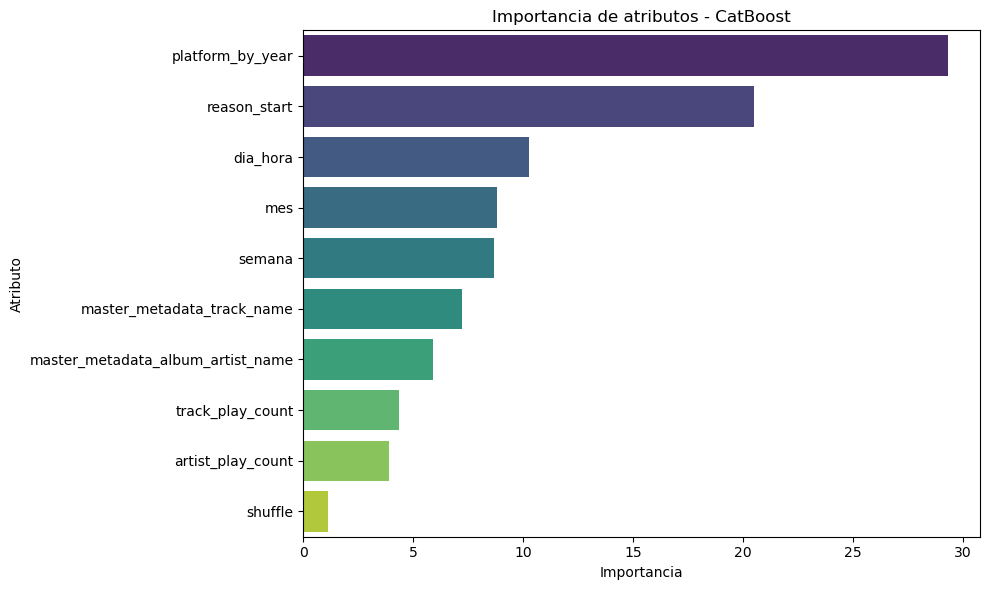

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
#Graficar correlaciones de atributos y target
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_importancia.head(20),  # Top 20 más importantes
    x='importancia', y='atributo', palette='viridis'
)
plt.title('Importancia de atributos - CatBoost')
plt.xlabel('Importancia')
plt.ylabel('Atributo')
plt.tight_layout()
plt.show()


### Genero file para submission de kaggle

In [19]:

'''submission = pd.read_csv("submission_con_generos.csv", index_col=0)

submission = modify_file(submission, categorical_cols)

# Predicción
df_predicciones = pd.DataFrame({
    'ID': submission.index,
    'TARGET': modelofinal.predict_proba(submission)[:, 1]
})

# Guardar en un archivo CSV
df_predicciones.to_csv("predicciones_catboost.csv", index=False)

print("Predicciones guardadas en 'predicciones_catboost.csv'")

'''

# Cargar archivo de submission
subm = pd.read_csv("submission.csv", index_col=0)

# Primero asegurate de convertir la fecha y extraer año antes de armar la columna
subm["ts"] = pd.to_datetime(subm["ts"], utc=True)
subm["año"] = subm["ts"].dt.year
subm["platform_by_year"] = subm["platform"].astype(str) + "_" + subm["año"].astype(str)

# Aplicar función de modificación general (para encoding de categóricas, fechas, etc.)
subm = modify_file(subm, categorical_cols)

# Aplicar misma lógica de mapeo desde X_train
subm['track_play_count'] = subm['master_metadata_track_name'].map(track_counts).fillna(0).astype(int)
subm['artist_play_count'] = subm['master_metadata_album_artist_name'].map(artist_counts).fillna(0).astype(int)


# Asegurarse de que las columnas estén en el mismo orden que espera el modelo
subm = subm[modelofinal.feature_names_]

# Crear columna de predicciones como ya la tenías
df_predicciones = pd.DataFrame({
    'ID': subm.index,
    'TARGET': modelofinal.predict_proba(subm)[:, 1]
})

# Guardar en CSV
df_predicciones.to_csv("predicciones_catboost.csv", index=False)

print("✅ Predicciones guardadas en 'predicciones_catboost.csv'")

✅ Predicciones guardadas en 'predicciones_catboost.csv'


/var/folders/jc/_3wsvphd4bgdb6n9q0pwhp0c0000gp/T/ipykernel_41479/161246092.py:25: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  f["ts"] = f["ts"].astype("int64") // 10**9
